# Retinal Scan Classifier
The goal of this project is to build a retinal scan classifier pipeline. The dataset consists of retinal scans alongside a csv file that provides labels for the scans. The retinal scans are labelled either healthy or unhealthy. Furthermore, the retinal scans are also labelled by different eye diseases. Note that an unhealthy eye can have more than one disease. The pipeline is broken up into two stages. Stage 1 uses machine learning to predict whether a retinal scan is healthy or unhealthy. Stage 2 attempts to successfully predict which specific eye diseases are present using machine learning. Stage 2 utilizes BinaryRelevance from skmultilearn to train multiple independent machine learning binary classifiers (one algorithm per disease). It also utilizes F1 threshold maximization to find the optimal threshold for identifying a disease. Note that the input to stage 2 are those scans that are known to be diseased (Disease_Risk = 1).

In [2]:
import pandas as pd
import os
import shutil
import glob
import gdown
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import math

# View Sample Images

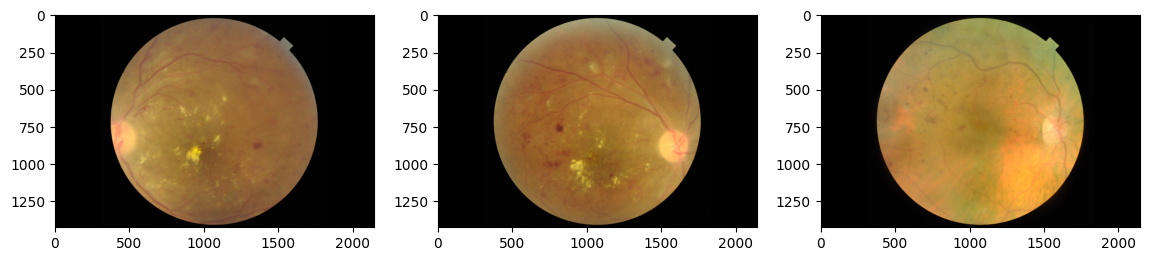

In [3]:
img_1 = Image.open('dataset/Combined_Set/images/1.png')
img_2 = Image.open('dataset/Combined_Set/images/2.png')
img_3 = Image.open('dataset/Test_Set/images/1.png')
plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.show()

# Two-Stage Machine Learning Pipeline

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import joblib
import numpy as np

In [5]:
#Constants
IMG_SIZE = (200, 300)
BATCH_SIZE = 32
SEED = 432

In [6]:
#Loading the dataset and doing preprocessing
def load_dataset(data_path):
    '''
    This function creates a dataframe out of a csv file. It also loads image data and
    their corresponding labels from a specified directory.

    Parameters:
        data_path (str): The root directory where the dataset is stored (i.e., 'dataset/Combined_Set/'
        or 'dataset/Test_Set/')

    Returns:
        df (pandas dataframe): This dataframe consists of the following:

                                An ID columnImage file paths

                                Image File Paths

                                A Disease_Risk column (binary values of 0 or 1)

                                45 disease label columns (binary values of 0 or 1).
    '''
    labels_path = os.path.join(data_path, 'labels.csv')
    images_path = os.path.join(data_path, 'images')
    df = pd.read_csv(labels_path)
    df['file_path'] = df['ID'].astype(str) + '.png'
    df['file_path'] = df['file_path'].apply(lambda x: os.path.join(images_path, x))
    df = df[df['file_path'].apply(os.path.exists)] #Drop missing images
    return df

In [7]:
def preprocess_image(file_path):
    '''
    This function takes the file path of an image and processes it so it's ready for use
    in our neural networks.

    Parameters:
        file_path (str): The path to an image file

    Returns:
        img_array (NumPy array): The image has been resized to IMG_SIZE and the pixel
        values have been normalized to the range 0-1.
    '''
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    return img_array

In [8]:
#print value_counts for the 45 disease columns
train_df = load_dataset("dataset/Combined_Set")
disease_cols = train_df.columns.tolist()
non_disease_cols = ['ID', 'file_path', 'Disease_Risk']
disease_cols = [col for col in disease_cols if col not in non_disease_cols]
print("\nValue Counts for Disease Columns:")
for col in disease_cols:
  print()
  print(train_df[col].value_counts())


Value Counts for Disease Columns:

DR
0    2052
1     508
Name: count, dtype: int64

ARMD
0    2422
1     138
Name: count, dtype: int64

MH
0    2141
1     419
Name: count, dtype: int64

DN
0    2376
1     184
Name: count, dtype: int64

MYA
0    2425
1     135
Name: count, dtype: int64

BRVO
0    2464
1      96
Name: count, dtype: int64

TSLN
0    2309
1     251
Name: count, dtype: int64

ERM
0    2539
1      21
Name: count, dtype: int64

LS
0    2496
1      64
Name: count, dtype: int64

MS
0    2540
1      20
Name: count, dtype: int64

CSR
0    2512
1      48
Name: count, dtype: int64

ODC
0    2206
1     354
Name: count, dtype: int64

CRVO
0    2524
1      36
Name: count, dtype: int64

TV
0    2552
1       8
Name: count, dtype: int64

AH
0    2540
1      20
Name: count, dtype: int64

ODP
0    2469
1      91
Name: count, dtype: int64

ODE
0    2481
1      79
Name: count, dtype: int64

ST
0    2551
1       9
Name: count, dtype: int64

AION
0    2538
1      22
Name: count, dtype: int64

In [9]:
#Dropping the rare diseases
#Exclude non-disease columns before summing
disease_cols_only = train_df.drop(columns=['ID', 'file_path', 'Disease_Risk'])
print("\nNumber of columns with at least 100 positive cases:")
print((disease_cols_only.sum() >= 100).sum())


Number of columns with at least 100 positive cases:
7


In [10]:
disease_cols_to_keep = disease_cols_only.columns[disease_cols_only.sum() >= 100].tolist()
train_df = train_df[['ID', 'file_path', 'Disease_Risk'] + disease_cols_to_keep]
print("\nShape of train_df after removing rare diseases:")
print(train_df.shape)
print("\nColumns remaining in train_risk_df:")
print(train_df.columns.tolist())


Shape of train_df after removing rare diseases:
(2560, 10)

Columns remaining in train_risk_df:
['ID', 'file_path', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'TSLN', 'ODC']


In [11]:
#Upsample diseases with less than 500 positive cases
min_positive_cases = 500
disease_cols_upsample = [col for col in disease_cols_to_keep if train_df[col].sum() < min_positive_cases]

upsampled_rows = []
for disease in disease_cols_upsample:
    positive_cases = train_df[train_df[disease] == 1]
    num_upsample = min_positive_cases - len(positive_cases)
    if num_upsample > 0:
        upsampled_rows.append(positive_cases.sample(num_upsample, replace=True, random_state=SEED))

if upsampled_rows:
    upsampled_df = pd.concat(upsampled_rows)
    train_df_upsampled = pd.concat([train_df, upsampled_df]).reset_index(drop=True)
else:
    train_df_upsampled = train_df.copy()

print("\nShape of train_df after upsampling:")
print(train_df_upsampled.shape)

print("\nValue Counts for Disease Columns after upsampling:")
for col in disease_cols_to_keep:
    print()
    print(train_df_upsampled[col].value_counts())


Shape of train_df after upsampling:
(4079, 10)

Value Counts for Disease Columns after upsampling:

DR
0    3492
1     587
Name: count, dtype: int64

ARMD
0    3417
1     662
Name: count, dtype: int64

MH
0    3401
1     678
Name: count, dtype: int64

DN
0    3535
1     544
Name: count, dtype: int64

MYA
0    3476
1     603
Name: count, dtype: int64

TSLN
0    3386
1     693
Name: count, dtype: int64

ODC
0    3362
1     717
Name: count, dtype: int64


In [12]:
#Shuffle the upsampled training dataframe
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [13]:
test_df = load_dataset("dataset/Test_Set")
test_df = test_df[['ID', 'file_path', 'Disease_Risk'] + disease_cols_to_keep]
print("\nShape of test_df after removing rare diseases:")
print(test_df.shape)
print("\nDisease columns remaining in test_df:")
print(test_df.columns.tolist())


Shape of test_df after removing rare diseases:
(640, 10)

Disease columns remaining in test_df:
['ID', 'file_path', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'TSLN', 'ODC']


# Stage 1: Disease Risk Binary Classifier

In [14]:
#Function to prepare the data
def prepare_stage1_data(df):
    '''
    This function takes in the dataframe from load_dataset and uses the preprocess_image
    function to process the images.

    Parameters:
        df (pandas dataframe): The dataframe that is outputted from load_dataset.

    Returns:
        X (NumPy array): A 4D NumPy array of the image data with shape (num_images, height, width, channels).
        y (NumPy array): The labels which serve as the target variable for the first neural network (Disease_Risk: 0, 1)
        with shape (num_samples,)
    '''
    X = np.array([preprocess_image(image) for image in df['file_path']])
    y = df['Disease_Risk'].values.astype(np.float32)
    return X, y

In [15]:
#Prepare data for Stage 1 (Disease Risk)
X1_train, y1_train = prepare_stage1_data(train_df_upsampled)
X1_test, y1_test = prepare_stage1_data(test_df)

In [16]:
#Define the feature extractor model
def build_feature_extractor(input_shape):
    '''
    Builds a feature extractor model using a pre-trained CNN (VGG16).

    Parameters:
        input_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        model (keras model): A Keras Model that outputs features.
    '''

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    #Add GlobalAveragePooling2D to reduce the dimensionality of the features
    x = GlobalAveragePooling2D()(x)
    #The model will output the features extracted from the base model
    model = Model(inputs=base_model.input, outputs=x)
    #Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [17]:
#Build the feature extractor model
feature_extractor = build_feature_extractor(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
print("Extracting Stage 1 features from training data...")
#Extract features for training data
X1_train_features = feature_extractor.predict(X1_train, batch_size=BATCH_SIZE)

Extracting Stage 1 features from training data...
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


In [19]:
print("Extracting Stage 1 features from test data...")
#Extract features for validation data
X1_test_features = feature_extractor.predict(X1_test, batch_size=BATCH_SIZE)

Extracting Stage 1 features from test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [20]:
#train ML models on these extracted features
#Define ML classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=SEED, class_weight='balanced'),
    'Support Vector Machine': SVC(probability=True, random_state=SEED, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
}


Training and evaluating ML classifiers for Stage 1...

--- Training Logistic Regression ---
Validation Metrics for Logistic Regression:
Accuracy:  0.8234375
Precision:  0.9318681318681319
Recall:  0.8379446640316206
F1 Score:  0.882414151925078
              precision    recall  f1-score   support

         0.0       0.56      0.77      0.65       134
         1.0       0.93      0.84      0.88       506

    accuracy                           0.82       640
   macro avg       0.74      0.80      0.76       640
weighted avg       0.85      0.82      0.83       640



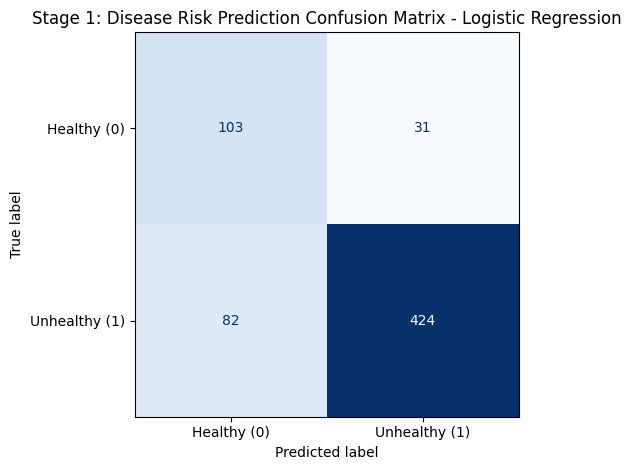


--- Training Support Vector Machine ---
Validation Metrics for Support Vector Machine:
Accuracy:  0.8453125
Precision:  0.9573033707865168
Recall:  0.841897233201581
F1 Score:  0.8958990536277602
              precision    recall  f1-score   support

         0.0       0.59      0.86      0.70       134
         1.0       0.96      0.84      0.90       506

    accuracy                           0.85       640
   macro avg       0.77      0.85      0.80       640
weighted avg       0.88      0.85      0.85       640



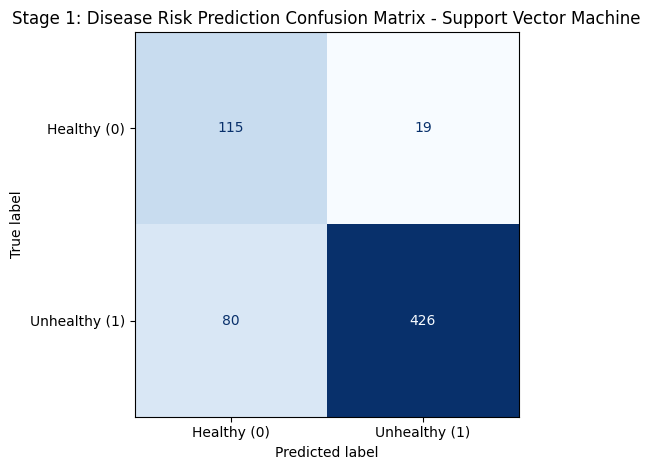


--- Training Random Forest ---
Validation Metrics for Random Forest:
Accuracy:  0.884375
Precision:  0.8970588235294118
Recall:  0.9644268774703557
F1 Score:  0.9295238095238095
              precision    recall  f1-score   support

         0.0       0.81      0.58      0.68       134
         1.0       0.90      0.96      0.93       506

    accuracy                           0.88       640
   macro avg       0.85      0.77      0.80       640
weighted avg       0.88      0.88      0.88       640



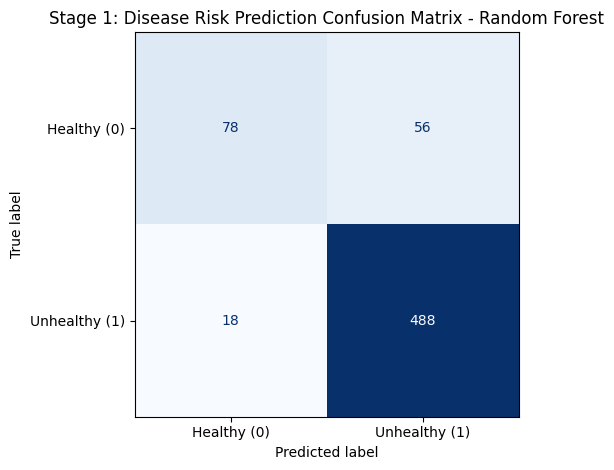

In [21]:
#Train and evaluate each classifier
print("\nTraining and evaluating ML classifiers for Stage 1...")

for name, classifier in classifiers.items():
    print(f"\n--- Training {name} ---")
    #Create a pipeline with a scaler and the classifier
    #Scaling the features is important for SVM and Logistic Regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (name, classifier)
    ])

    #Train the pipeline
    pipeline.fit(X1_train_features, y1_train)

    #Evaluate on the test set
    y_test_pred = pipeline.predict(X1_test_features)
    print(f"Validation Metrics for {name}:")
    print("Accuracy: ", accuracy_score(y1_test, y_test_pred))
    print("Precision: ", precision_score(y1_test, y_test_pred))
    print("Recall: ", recall_score(y1_test, y_test_pred))
    print("F1 Score: ", f1_score(y1_test, y_test_pred))
    print(classification_report(y1_test, y_test_pred))

    #Confusion Matrix Stage 1
    cm = confusion_matrix(y1_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy (0)', 'Unhealthy (1)'])
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f"Stage 1: Disease Risk Prediction Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# Stage 2: Multi-Label Classifier

In [22]:
#Function to prepare the data
def prepare_stage2_data(df):
    '''
    This function prepares a dataset for multi-label classification. That is,
    each image can be associated with multiple disease labels.

    Parameters:
        df (pandas dataframe): The dataframe that is outputted from load_dataset.

    Returns:
        X (NumPy array): A 4D NumPy array of the image data with shape (num_images, height, width, channels).
        y (NumPy array): Multi-label target array (0s and 1s) with shape (num_samples, num_diseases).
        disease_cols (list): A list of containing the names of the diseases.
    '''
    disease_cols = df.columns.tolist()
    # Remove columns that are not disease labels
    non_disease_cols = ['ID', 'file_path', 'Disease_Risk']
    disease_cols = [col for col in disease_cols if col not in non_disease_cols]
    X = np.array([preprocess_image(image) for image in df['file_path']])
    y = df[disease_cols].values.astype(np.float32)
    return X, y, disease_cols

In [23]:
#Filter training and test data for stage 2 (known risk cases only)
known_risk_train_df = train_df_upsampled[train_df_upsampled['Disease_Risk'] == 1].copy()
known_risk_test_df = test_df[test_df['Disease_Risk'] == 1].copy()

In [24]:
#Prepare data for Stage 2: Need the raw image data (X) and the multi-label targets (y)
X2_train_upsampled_raw, y2_train_upsampled_multi, disease_names = prepare_stage2_data(known_risk_train_df)
X2_test_raw, y2_test_multi, _ = prepare_stage2_data(known_risk_test_df)

In [25]:
#Define the feature extractor model using VGG16
def build_vgg16_feature_extractor(input_shape):
    '''
    Builds a feature extractor model using a pre-trained VGG16.

    Parameters:
        input_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        model (keras model): A Keras Model that outputs features from the VGG16 base.
    '''
    #Load the VGG16 model pre-trained on ImageNet, excluding the top dense layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    #The output of the base model is the convolutional feature maps
    x = base_model.output

    #Add GlobalAveragePooling2D to reduce the dimensionality of the features
    x = GlobalAveragePooling2D()(x) #creates a vector of features per image

    #Create a Keras Model that takes the input image and outputs the pooled features
    model = Model(inputs=base_model.input, outputs=x)

    #Freeze the weights of the pre-trained layers initially
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [26]:
#Build the VGG16 feature extractor model for Stage 2
vgg16_feature_extractor_stage2 = build_vgg16_feature_extractor(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [27]:
print("\nExtracting Stage 2 features from upsampled training data using VGG16...")
#Extract features for the upsampled training data
X2_train_upsampled_features = vgg16_feature_extractor_stage2.predict(X2_train_upsampled_raw, batch_size=BATCH_SIZE)


Extracting Stage 2 features from upsampled training data using VGG16...
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


In [28]:
print("Extracting Stage 2 features from test data using VGG16...")
#Extract features for the test data
X2_test_features = vgg16_feature_extractor_stage2.predict(X2_test_raw, batch_size=BATCH_SIZE)

Extracting Stage 2 features from test data using VGG16...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


In [31]:
#Modified DenseBinaryRelevanceWithThresholdsML class
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as sk_f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


class MLBinaryClassifierWithProbs(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier):
        self.classifier = classifier
        self.pipeline = None

    def fit(self, X, y):
        y = np.asarray(y)
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clone(self.classifier))
        ])
        self.pipeline.fit(X, y)
        return self

    def predict_proba(self, X):
        if not hasattr(self.pipeline.named_steps['classifier'], 'predict_proba'):
            raise AttributeError("Base classifier must have predict_proba method.")
        proba = self.pipeline.predict_proba(X)
        if proba.shape[1] != 2:
             raise ValueError("Base classifier's predict_proba did not return 2 columns for binary classification.")
        return proba[:, 1]


    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    def get_params(self, deep=True):
        params = super().get_params(deep=deep)
        if self.pipeline:
            pipeline_params = self.pipeline.get_params(deep=deep)
            for key, value in pipeline_params.items():
                params[f'pipeline__{key}'] = value
        params['classifier'] = self.classifier
        return params


    def set_params(self, **params):
        if 'classifier' in params:
            self.classifier = params.pop('classifier')
            self.pipeline = None
        if self.pipeline:
             pipeline_params = {}
             for key, value in params.items():
                if key.startswith('pipeline__'):
                    pipeline_params[key] = value
             if pipeline_params:
                 self.pipeline.set_params(**pipeline_params)
             params = {k: v for k, v in params.items() if not k.startswith('pipeline__')}
        super().set_params(**params)
        return self


class DenseBinaryRelevanceWithThresholdsML(BinaryRelevance):
    def fit(self, X, y):
        y = np.asarray(y, dtype=np.float32)
        self._label_count = y.shape[1]
        self.classifiers = []
        self.thresholds = []
        self.fitted_labels_ = []

        X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
            X, y, test_size=0.2, random_state=SEED
        )

        def find_optimal_threshold(y_true, y_probs):
            '''
            Finds the optimal probability threshold for a binary classifier
            to maximize the F1 score.

            Parameters:
                y_true (array): True binary labels (0 or 1).
                y_probs (array): Predicted probabilities (0 to 1).

            Returns:
                optimal_threshold (float): The threshold that yields the highest F1 score.
                optimal_f1 (float): The highest F1 score achieved at the optimal threshold.
            '''

            unique_classes_true = np.unique(y_true)
            if len(unique_classes_true) < 2:
                 return 0.5, 0.0

            precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
            if len(thresholds) == 0:
                 return 0.5, 0.0

            thresholds = np.sort(np.unique(np.append(thresholds, [0.0, 1.0])))
            f1_scores = []
            for i in range(len(thresholds)):
                y_pred = (y_probs >= thresholds[i]).astype(int)
                f1 = sk_f1_score(y_true, y_pred, zero_division=0)
                f1_scores.append(f1)

            if not f1_scores or np.all(f1_scores == 0):
                 return 0.5, 0.0

            max_f1 = np.max(f1_scores)
            optimal_indices = np.where(f1_scores == max_f1)[0]
            optimal_idx = optimal_indices[0]

            optimal_threshold = thresholds[optimal_idx]
            optimal_f1 = f1_scores[optimal_idx]

            return optimal_threshold, optimal_f1

        for label in range(self._label_count):
            label_name = disease_names[label] if len(disease_names) > label else f"Label {label}"
            print(f"Processing classifier for {label_name} ({label+1}/{self._label_count})...")

            y_train_label_all = y_train_all[:, label]
            y_val_label_all = y_val_all[:, label]

            unique_classes_train_all = np.unique(y_train_label_all)

            if len(unique_classes_train_all) < 2:
                print(f"  Warning: Training data for '{label_name}' has only one class ({unique_classes_train_all[0]}). Cannot train a binary classifier.")
                self.classifiers.append(None)
                self.thresholds.append(0.5)
                continue

            classes, counts = np.unique(y_train_label_all, return_counts=True)
            total_count = counts.sum()
            class_weight = {c: total_count / (len(classes) * count) for c, count in zip(classes, counts) if count > 0}
            if 0 not in class_weight and 0 in unique_classes_train_all:
                 class_weight[0] = total_count / (len(classes) * 1)
            if 1 not in class_weight and 1 in unique_classes_train_all:
                 class_weight[1] = total_count / (len(classes) * 1)
            try:
                X_train_clf, X_val_clf_inner, y_train_clf, y_val_clf_inner = train_test_split(
                    X_train_all, y_train_label_all, test_size=0.25, random_state=SEED, stratify=y_train_label_all
                )
                if len(np.unique(y_train_clf)) < 2:
                    raise ValueError("Inner split resulted in only one class for training.")

            except ValueError as e:
                print(f"  Warning: Stratification failed for '{label_name}' in inner split or inner training split has only one class. Skipping stratification. Error: {e}")
                try:
                    X_train_clf, X_val_clf_inner, y_train_clf, y_val_clf_inner = train_test_split(
                        X_train_all, y_train_label_all, test_size=0.25, random_state=SEED
                    )
                    if len(np.unique(y_train_clf)) < 2:
                         print(f"  Warning: Simple inner split for '{label_name}' also resulted in only one class for training. Skipping training for this label.")
                         self.classifiers.append(None)
                         self.thresholds.append(0.5)
                         continue
                except Exception as inner_e:
                    print(f"  Error during simple inner split for '{label_name}': {inner_e}. Skipping training for this label.")
                    self.classifiers.append(None)
                    self.thresholds.append(0.5)
                    continue

            base_clf_clone = clone(self.classifier)
            if 'class_weight' in base_clf_clone.get_params():
                 base_clf_clone.set_params(class_weight=class_weight if class_weight else None)

            clf = MLBinaryClassifierWithProbs(classifier=base_clf_clone)

            try:
                clf.fit(X_train_clf, y_train_clf)
                self.classifiers.append(clf)
                self.fitted_labels_.append(label)
                y_val_probs_inner = clf.predict_proba(X_val_clf_inner)
                if y_val_probs_inner.ndim > 1:
                    y_val_probs_inner = y_val_probs_inner.flatten()


                optimal_threshold, optimal_f1 = find_optimal_threshold(y_val_clf_inner, y_val_probs_inner)
                self.thresholds.append(optimal_threshold)
                print(f"  Successfully trained and found optimal threshold for '{label_name}': {optimal_threshold:.4f} (Inner Validation F1: {optimal_f1:.4f})")

            except Exception as fit_e:
                print(f"  Error fitting classifier for '{label_name}': {fit_e}. Skipping training for this label.")
                self.classifiers.append(None)
                self.thresholds.append(0.5)


        print("Training complete.")
        while len(self.classifiers) < self._label_count:
             self.classifiers.append(None)
             self.thresholds.append(0.5)
        return self

    def predict(self, X):
        #Generate predictions from each classifier using its optimal threshold
        predictions = []
        for i in range(self._label_count):
            clf = self.classifiers[i]
            threshold = self.thresholds[i]

            if clf is None:
                 preds = np.zeros((X.shape[0], 1), dtype=int)
            else:
                try:
                    preds = clf.predict(X, threshold=threshold).reshape(-1, 1)
                except Exception as predict_e:
                     print(f"  Error during prediction for label {i} ('{disease_names[i] if len(disease_names) > i else f'Label {i}'}'): {predict_e}. Predicting 0.")
                     preds = np.zeros((X.shape[0], 1), dtype=int)

            predictions.append(preds)

        if not predictions:
             return np.zeros((X.shape[0], self._label_count), dtype=int)

        return np.hstack(predictions).astype(int)

    def get_params(self, deep=True):
        params = super().get_params(deep=deep)
        if hasattr(self, 'classifier'):
            base_clf_params = self.classifier.get_params(deep=deep)
            for key, value in base_clf_params.items():
                params[f'classifier__{key}'] = value
        if hasattr(self, 'require_dense'):
             params['require_dense'] = self.require_dense
        return params

    def set_params(self, **params):
        if 'require_dense' in params:
            self.require_dense = params.pop('require_dense')
        classifier_params = {}
        for key, value in list(params.items()):
             if key.startswith('classifier__'):
                 classifier_params[key[len('classifier__'):]] = value
                 params.pop(key)

        if classifier_params:
             if hasattr(self, 'classifier') and self.classifier is not None:
                 try:
                    self.classifier.set_params(**classifier_params)
                 except AttributeError as e:
                    print(f"Warning: Could not set params {classifier_params} on base classifier {type(self.classifier).__name__}: {e}")
             else:
                  print(f"Warning: Attempted to set classifier params {classifier_params} but base classifier is not initialized or None.")

        pipeline_params = {}
        for key, value in list(params.items()):
            if key.startswith('pipeline__'):
                 pipeline_params[key] = value
                 params.pop(key)
        if pipeline_params:
             print(f"Warning: Ignoring pipeline parameters {pipeline_params} in DenseBinaryRelevanceWithThresholdsML. Set these on the base classifier instance before initialization.")

        super().set_params(**params)
        return self


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Re-define your BinaryRelevance classifiers using the modified wrapper
br_classifier_svm_optimized = DenseBinaryRelevanceWithThresholdsML(
    classifier=SVC(probability=True, random_state=SEED),
    require_dense=[True, True])

br_classifier_rf_optimized = DenseBinaryRelevanceWithThresholdsML(
    classifier=RandomForestClassifier(n_estimators=100, random_state=SEED),
    require_dense=[True, True])

In [32]:
y2_train_upsampled_multi = np.asarray(y2_train_upsampled_multi, dtype=np.float32)

In [33]:
#Train the optimized BinaryRelevance models using the extracted features from upsampled training data
print("\nTraining Optimized BinaryRelevance (SVM) classifiers for Stage 2...")
br_classifier_svm_optimized.fit(X2_train_upsampled_features, y2_train_upsampled_multi)


Training Optimized BinaryRelevance (SVM) classifiers for Stage 2...
Processing classifier for DR (1/7)...
  Successfully trained and found optimal threshold for 'DR': 0.3599 (Inner Validation F1: 0.6275)
Processing classifier for ARMD (2/7)...
  Successfully trained and found optimal threshold for 'ARMD': 0.6053 (Inner Validation F1: 0.9365)
Processing classifier for MH (3/7)...
  Successfully trained and found optimal threshold for 'MH': 0.5073 (Inner Validation F1: 0.8333)
Processing classifier for DN (4/7)...
  Successfully trained and found optimal threshold for 'DN': 0.5134 (Inner Validation F1: 0.7921)
Processing classifier for MYA (5/7)...
  Successfully trained and found optimal threshold for 'MYA': 0.8037 (Inner Validation F1: 0.9958)
Processing classifier for TSLN (6/7)...
  Successfully trained and found optimal threshold for 'TSLN': 0.3589 (Inner Validation F1: 0.7527)
Processing classifier for ODC (7/7)...
  Successfully trained and found optimal threshold for 'ODC': 0.45

DenseBinaryRelevanceWithThresholdsML(classifier=SVC(probability=True,
                                                    random_state=432),
                                     classifier__C=1.0,
                                     classifier__break_ties=False,
                                     classifier__cache_size=200,
                                     classifier__class_weight=None,
                                     classifier__coef0=0.0,
                                     classifier__decision_function_shape='ovr',
                                     classifier__degree=3,
                                     classifier__gamma='scale',
                                     classifier__kernel='rbf',
                                     classifier__max_iter=-1,
                                     classifier__probability=True,
                                     classifier__random_state=432,
                                     classifier__shrinking=True,
                                     classifier__tol=0.001,
                                     classifier__verbose=False,
                                     require_dense=[True, True])

In [34]:
print("\nTraining Optimized BinaryRelevance (RF) classifiers for Stage 2...")
br_classifier_rf_optimized.fit(X2_train_upsampled_features, y2_train_upsampled_multi)


Training Optimized BinaryRelevance (RF) classifiers for Stage 2...
Processing classifier for DR (1/7)...
  Successfully trained and found optimal threshold for 'DR': 0.2700 (Inner Validation F1: 0.7603)
Processing classifier for ARMD (2/7)...
  Successfully trained and found optimal threshold for 'ARMD': 0.5600 (Inner Validation F1: 0.9804)
Processing classifier for MH (3/7)...
  Successfully trained and found optimal threshold for 'MH': 0.3800 (Inner Validation F1: 0.8636)
Processing classifier for DN (4/7)...
  Successfully trained and found optimal threshold for 'DN': 0.6000 (Inner Validation F1: 0.8900)
Processing classifier for MYA (5/7)...
  Successfully trained and found optimal threshold for 'MYA': 0.3500 (Inner Validation F1: 0.9958)
Processing classifier for TSLN (6/7)...
  Successfully trained and found optimal threshold for 'TSLN': 0.3400 (Inner Validation F1: 0.8607)
Processing classifier for ODC (7/7)...
  Successfully trained and found optimal threshold for 'ODC': 0.400

DenseBinaryRelevanceWithThresholdsML(classifier=RandomForestClassifier(random_state=432),
                                     classifier__bootstrap=True,
                                     classifier__ccp_alpha=0.0,
                                     classifier__class_weight=None,
                                     classifier__criterion='gini',
                                     classifier__max_depth=None,
                                     classifier__max_features='sqrt',
                                     classifier__max_leaf_nodes=None,
                                     classifier__max_samples=None,
                                     classifier__min_impurity_decrease=0.0,
                                     classifier__min_samples_leaf=1,
                                     classifier__min_samples_split=2,
                                     classifier__min_weight_fraction_leaf=0.0,
                                     classifier__monotonic_cst=None,
                                     classifier__n_estimators=100,
                                     classifier__n_jobs=None,
                                     classifier__oob_score=False,
                                     classifier__random_state=432,
                                     classifier__verbose=0,
                                     classifier__warm_start=False,
                                     require_dense=[True, True])

In [35]:
best_stage1_model_name = 'Random Forest'
best_stage1_pipeline = classifiers[best_stage1_model_name] #Get the trained pipeline for Stage 1

In [36]:
def evaluate_test_set_full_pipeline(df, feature_extractor, stage1_pipeline, feature_extractor_stage2, br_classifier_stage2, disease_names, risk_threshold=0.5, save_path=None, verbose=True, zero_division='warn'):
    '''
    This function performs end-to-end evaluation on a test dataset for the full two-stage ML pipeline:

            Stage 1: Predicts whether an image indicates high disease risk using ML on extracted features.

            Stage 2: For known diseased eyes, predicts specific diseases (multi-label classification)
                     using Binary Relevance (ML on extracted features) with threshold optimization.

    Parameters:
        df (pandas dataframe): The test set dataframe (from load_dataset).
        feature_extractor (keras model): The feature extractor model for Stage 1 (e.g., VGG16).
        stage1_pipeline (sklearn pipeline): The trained pipeline for Stage 1 (e.g., StandardScaler + SVM).
        feature_extractor_stage2 (keras model): The feature extractor model for Stage 2 (e.g., VGG16).
        br_classifier_stage2 (skmultilearn BinaryRelevance classifier): The trained BinaryRelevance model for stage 2.
        disease_names (list): A list of disease labels
        risk_threshold (float): Probability cutoff for classifying Stage 1 Disease_Risk predictions (default: 0.5).
        save_path (str): Optional file path to save predictions as a CSV.
        verbose (bool): Print out evaluation metrics.
        zero_division ('warn', 0, 1): Sets the value to return when there is a zero division.

    Returns:
        final_results (pandas dataframe): The final predictions.
    '''
    #Preprocess all test images once
    X_test_raw = np.array([preprocess_image(image) for image in df['file_path']])

    # --- Stage 1 Predictions ---
    print("\nPerforming Stage 1 predictions...")
    #stage1_pipeline takes features as input, we need to extract them first.
    X_test_features_stage1 = feature_extractor.predict(X_test_raw, batch_size=BATCH_SIZE)
    risk_probs = stage1_pipeline.predict_proba(X_test_features_stage1)[:, 1] # Get probability of the positive class
    df['predicted_risk'] = (risk_probs >= risk_threshold).astype(int)
    df['risk_score'] = risk_probs

    #If ground-truth Disease_Risk labels are available:
    #Computes and prints: Accuracy, Precision, Recall, F1 Score.
    if 'Disease_Risk' in df.columns and verbose:
        y_true_risk = df['Disease_Risk'].values
        y_pred_risk = df['predicted_risk'].values
        print("Stage 1 Metrics:")
        print("Accuracy:", accuracy_score(y_true_risk, y_pred_risk))
        print("Precision:", precision_score(y_true_risk, y_pred_risk, zero_division=zero_division))
        print("Recall:", recall_score(y_true_risk, y_pred_risk, zero_division=zero_division))
        print("F1 Score:", f1_score(y_true_risk, y_pred_risk, zero_division=zero_division))

        #Confusion Matrix Stage 1
        cm = confusion_matrix(y_true_risk, y_pred_risk)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy (0)', 'Unhealthy (1)'])
        disp.plot(cmap='Blues', values_format='d', colorbar=False)
        plt.title(f"Stage 1: Disease Risk Prediction Confusion Matrix - {best_stage1_model_name}")
        plt.tight_layout()
        plt.show()

    # --- Stage 2 Predictions ---
    print("\nPerforming Stage 2 predictions (for disease risk=1 cases)...")
    known_risk_df = df[df['Disease_Risk'] == 1].copy()

    if len(known_risk_df) > 0:
        #Get raw images for these cases to extract features
        X_pred_risk_raw = np.array([preprocess_image(image) for image in known_risk_df['file_path']])

        #Extract features for Stage 2 from these images
        X_pred_risk_features = feature_extractor_stage2.predict(X_pred_risk_raw, batch_size=BATCH_SIZE)

        #Predict for each single-label classifier in the BR model
        disease_preds = br_classifier_stage2.predict(X_pred_risk_features) #Uses internal optimal thresholds
        for i, disease in enumerate(disease_names):
            known_risk_df[f'predicted_{disease}'] = disease_preds[:, i]

        #Computes Micro F1 (global average) and Macro F1 (average per disease).
        if all(d in known_risk_df.columns for d in disease_names) and verbose:
            y2_true_multi = known_risk_df[disease_names].values
            y2_pred_multi = disease_preds
            print("Stage 2 Metrics (Disease_Risk == 1 Subset):")
            print("Subset Accuracy:", accuracy_score(y2_true_multi, y2_pred_multi))
            print("Micro F1:", f1_score(y2_true_multi, y2_pred_multi, average='micro', zero_division=zero_division))
            print("Macro F1:", f1_score(y2_true_multi, y2_pred_multi, average='macro', zero_division=zero_division))

    else:
        print("No Disease_Risk == 1 cases in the test set for Stage 2 evaluation.")
        # If no Disease_Risk == 1 cases, add empty prediction columns
        predicted_disease_cols = [f'predicted_{d}' for d in disease_names]
        for col in predicted_disease_cols:
            known_risk_df[col] = [] #empty series


    #Merge disease predictions back into the full test DataFrame using the ID column.
    #Any image that wasn’t predicted risk gets 0s for all diseases
    final_results = df.copy()

    #Add predicted disease columns, defaulting to 0.
    for d in disease_names:
        final_results[f'predicted_{d}'] = 0 #Initialize with 0

    #Update predictions only for rows present in known_risk_df
    if not known_risk_df.empty:
        #Ensure known_risk_df has only necessary columns for merging
        cols_to_merge = ['ID'] + [f'predicted_{d}' for d in disease_names]
        #Align indices before using update
        final_results = final_results.set_index('ID')
        known_risk_df_indexed = known_risk_df[cols_to_merge].set_index('ID')
        final_results.update(known_risk_df_indexed)
        final_results = final_results.reset_index()

    #Ensure disease prediction columns are integer type
    for d in disease_names:
         final_results[f'predicted_{d}'] = final_results[f'predicted_{d}'].fillna(0).astype(int)

    if save_path:
        final_results.to_csv(save_path, index=False)
        if verbose:
            print(f"\nSaved predictions to {save_path}")

    #Returning the DataFrame with predictions and scores, including:
    #risk_score, predicted_risk, predicted_eye_disease1, predicted_eye_disease2, etc.
    return final_results


Evaluating with Optimized svm BR (Stage 2)...

Performing Stage 1 predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Stage 1 Metrics:
Accuracy: 0.790625
Precision: 0.790625
Recall: 1.0
F1 Score: 0.8830715532286213


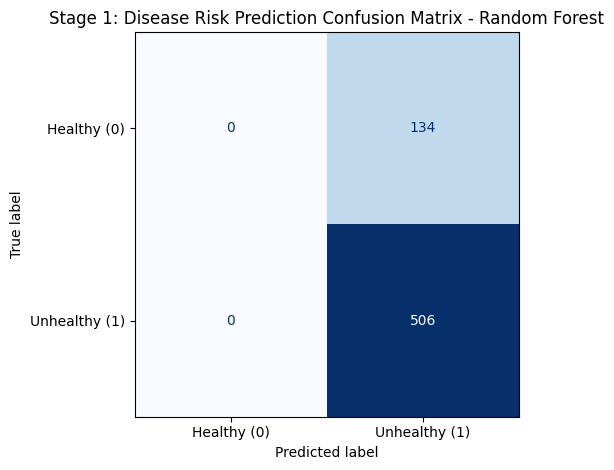


Performing Stage 2 predictions (for disease risk=1 cases)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Stage 2 Metrics (Disease_Risk == 1 Subset):
Subset Accuracy: 0.43478260869565216
Micro F1: 0.49101796407185627
Macro F1: 0.36398696147580695

Saved predictions to predicted_test_results_full_pipeline_svm.csv


In [37]:
#Evaluate using Optimized SVM BR for Stage 2
print("\nEvaluating with Optimized svm BR (Stage 2)...")
results_full_pipeline_svm = evaluate_test_set_full_pipeline(
    df=test_df,
    feature_extractor=feature_extractor,
    stage1_pipeline=best_stage1_pipeline,
    feature_extractor_stage2=vgg16_feature_extractor_stage2,
    br_classifier_stage2=br_classifier_svm_optimized,
    disease_names=disease_names,
    risk_threshold=0.5, #Stage 1 Threshold
    save_path="predicted_test_results_full_pipeline_svm.csv",
    zero_division=0)


Evaluating with Optimized RF BR (Stage 2)...

Performing Stage 1 predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Stage 1 Metrics:
Accuracy: 0.790625
Precision: 0.790625
Recall: 1.0
F1 Score: 0.8830715532286213


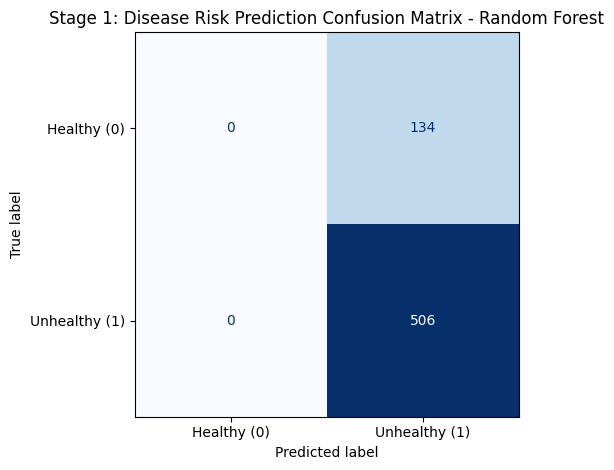


Performing Stage 2 predictions (for disease risk=1 cases)...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Stage 2 Metrics (Disease_Risk == 1 Subset):
Subset Accuracy: 0.47035573122529645
Micro F1: 0.5073170731707317
Macro F1: 0.3269864584933078

Saved predictions to predicted_test_results_full_pipeline_rf.csv


In [38]:
#Evaluate using Optimized RF BR for Stage 2
print("\nEvaluating with Optimized RF BR (Stage 2)...")
results_full_pipeline_rf = evaluate_test_set_full_pipeline(
    df=test_df,
    feature_extractor=feature_extractor,
    stage1_pipeline=best_stage1_pipeline,
    feature_extractor_stage2=vgg16_feature_extractor_stage2,
    br_classifier_stage2=br_classifier_rf_optimized,
    disease_names=disease_names,
    risk_threshold=0.5, #Stage 1 threshold
    save_path="predicted_test_results_full_pipeline_rf.csv",
    zero_division=0
)

#Visualizations

In [39]:
def visualize_predictions(results_df, disease_names, num_samples=5):
    '''
    This function creates image visualizations with model-predicted disease labels for a sample of known-risk cases.
    It allows us to see what the model predicted, and which diseases it thinks are present,
    directly on the images.

    Parameters:
        results_df (pandas dataframe): The dataframe returned by the evaluate_test_set function which contains the predictions.
        disease_names (list): A list of disease labels.
        num_samples (int): Number of random high-risk images to visualize.
    '''
    known_risk_df = results_df[results_df['Disease_Risk'] == 1]
    #Randomly selects up to num_samples from the known-risk cases
    samples = known_risk_df.sample(min(num_samples, len(known_risk_df)))

    for _, row in samples.iterrows():
        img = load_img(row['file_path'], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        #Extracts all diseases that were predicted as present for this image
        predicted_diseases = [d for d in disease_names if row.get(f'predicted_{d}', 0) == 1]

        if all(d in row for d in disease_names):
            true_diseases = [d for d in disease_names if row[d] == 1]
        else:
            true_diseases = []

        title = f"Predicted Risk: 1\n"
        title += f"Predicted: {', '.join(predicted_diseases) if predicted_diseases else 'None'}\n"
        title += f"True: {', '.join(true_diseases) if true_diseases else 'Unknown'}"

        plt.figure(figsize=(6,6))
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(title, fontsize=10)
        plt.tight_layout()
        #Show the image directly in the notebook
        plt.show()

    print(f"Displayed {len(samples)} visualizations.")

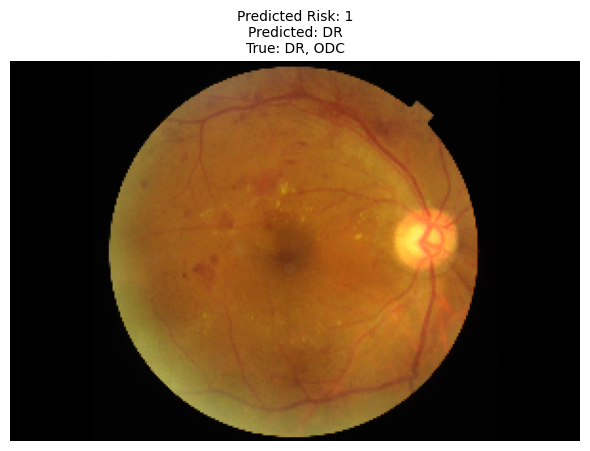

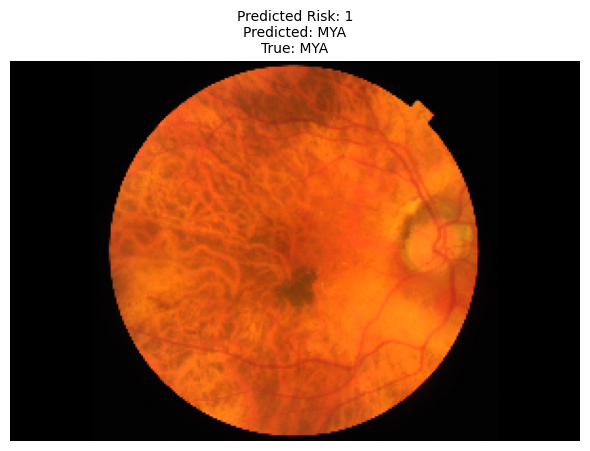

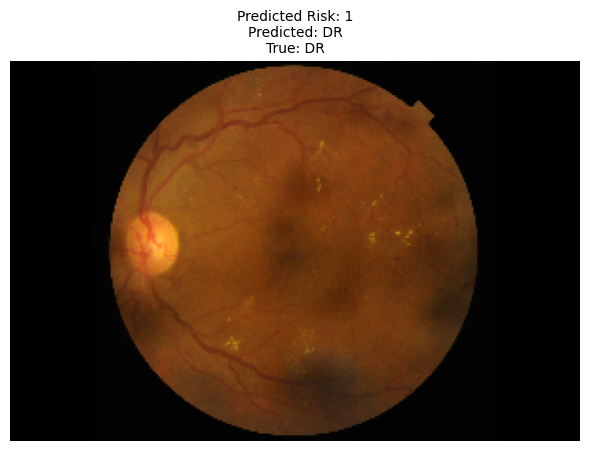

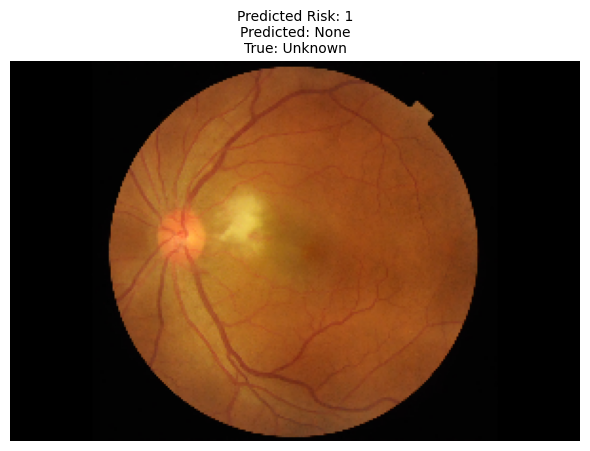

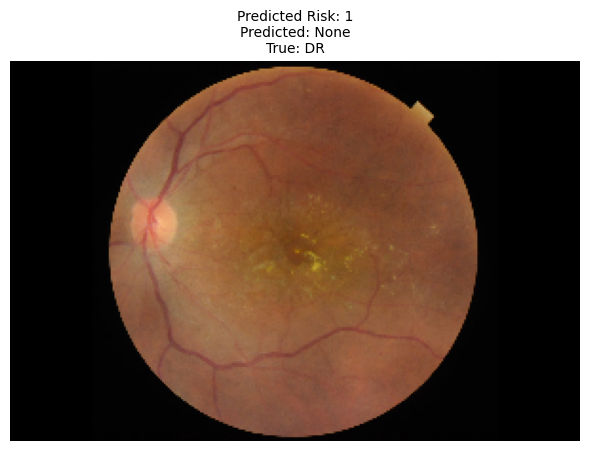

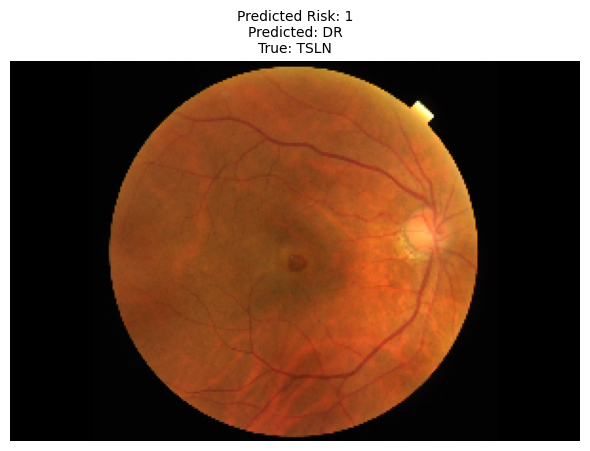

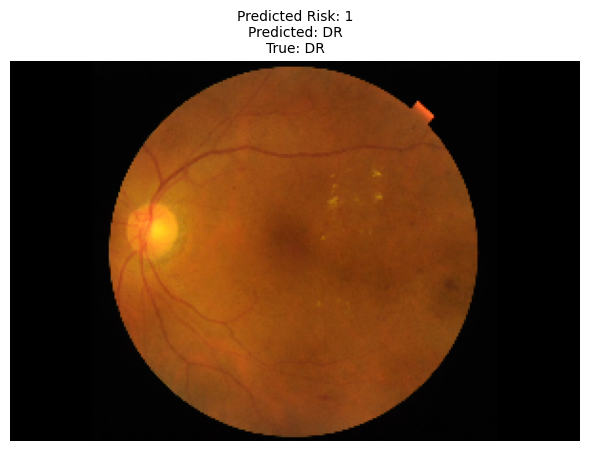

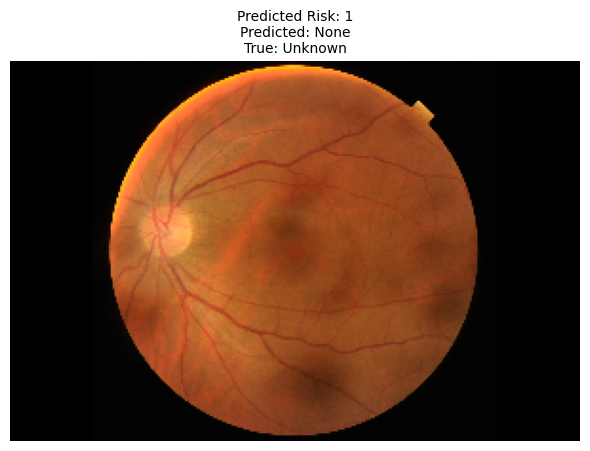

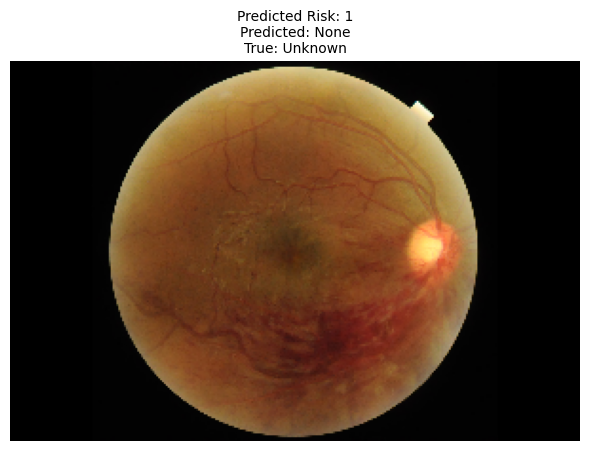

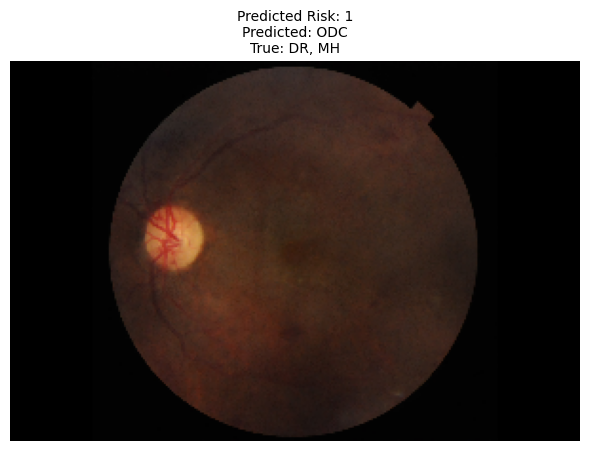

Displayed 10 visualizations.


In [41]:
#Visualize predictions for the results from one of the full pipelines (e.g., svm Stage 2)
visualize_predictions(results_full_pipeline_svm, disease_names, num_samples=10)

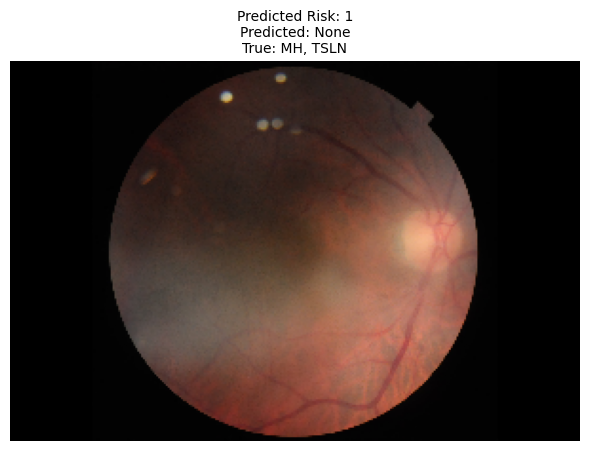

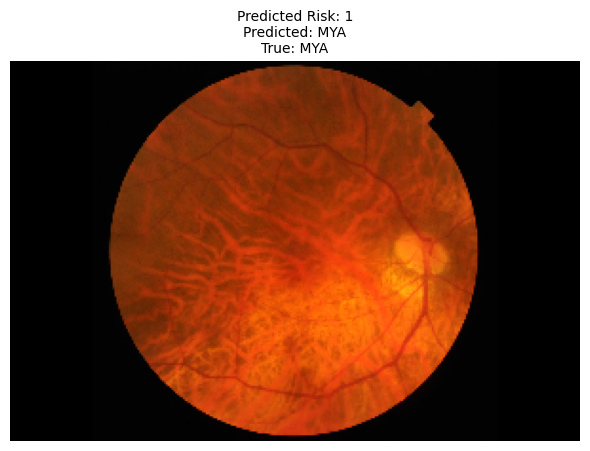

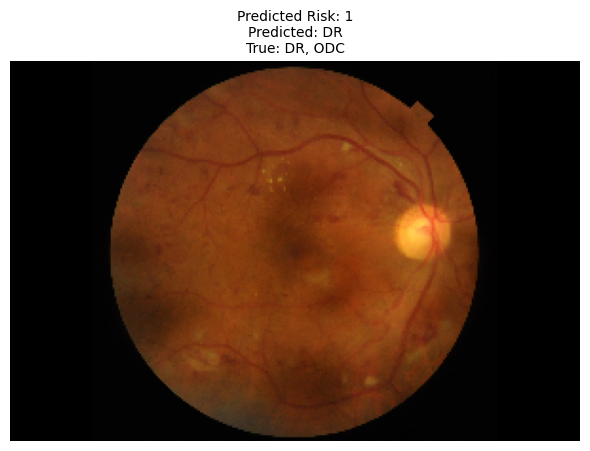

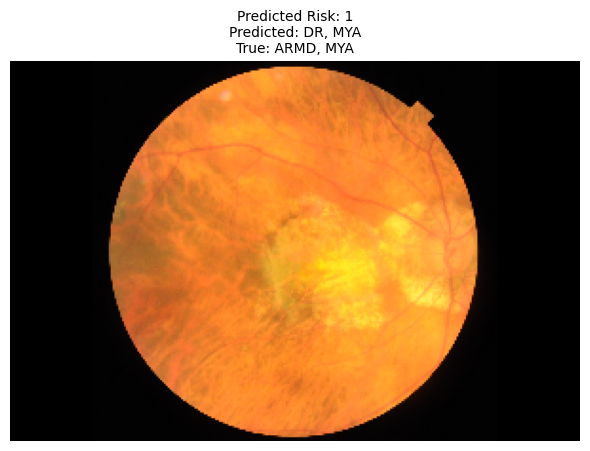

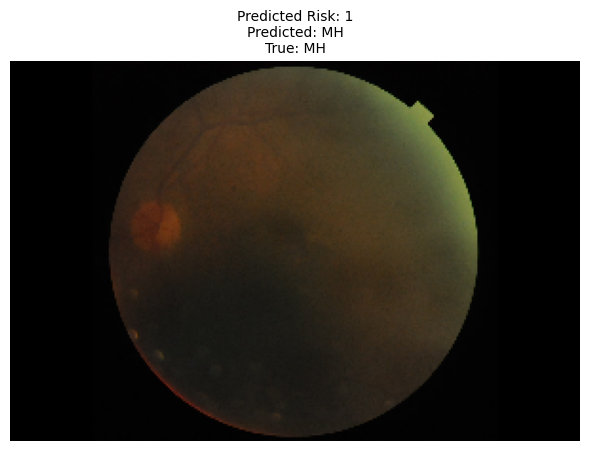

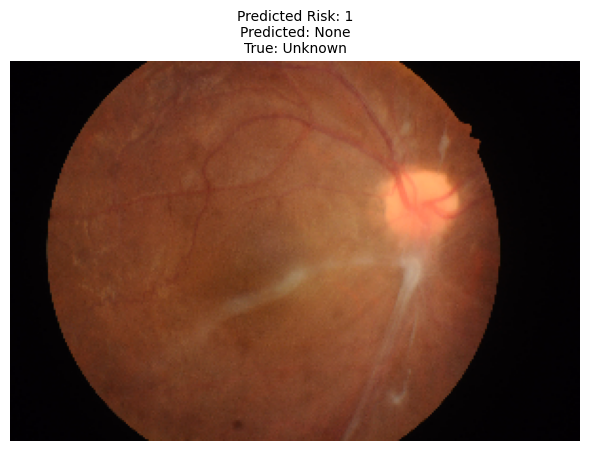

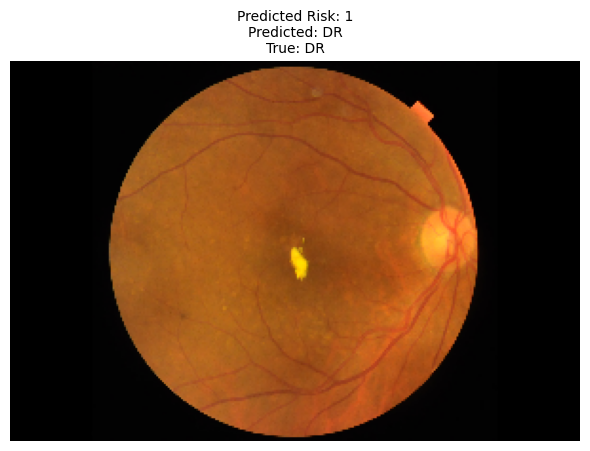

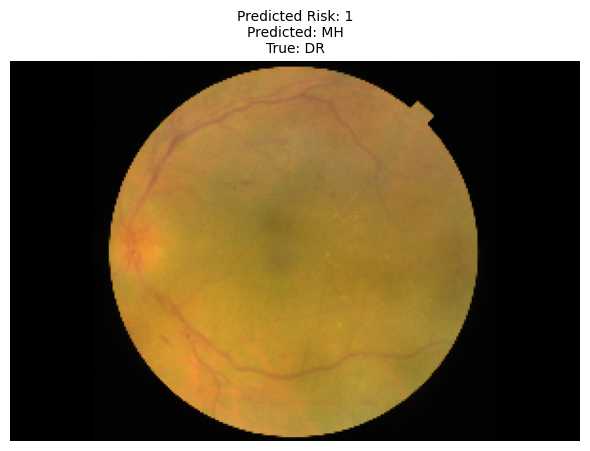

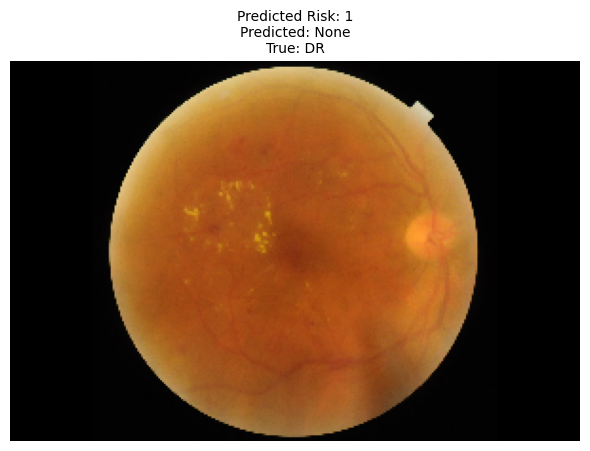

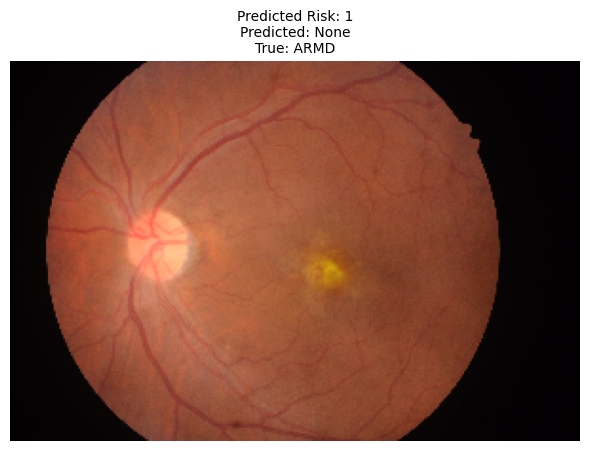

Displayed 10 visualizations.


In [50]:
visualize_predictions(results_full_pipeline_rf, disease_names, num_samples=10)